# Classification d'images : Partie 2, la méthode new school

## Sujet de cette partie

Cette partie, la partie 2, fera appel à une modélisation de l’information conjointe entre
les attributs d’une image et sa classe d’appartenance via un réseau de neurones (neural
network ou NN). Dans ce cas, nous verrons qu’il ne sera pas nécessaire de passer par une étape
d’extraction de primitives, elle se fera naturellement dans le réseau de neurones.

## Keras

Keras est une API de haut niveau écrite en python et qui permet d'interagir avec des réseaux de neurones. Elle permet notamment d'interagir avec Tensorflow par exemple.

Keras est créé pour être utilisé par des humains avant tout, l'expérience utilisateur est donc importante, notamment sur la clarté des erreurs affichées durant le développement.

Keras est modulaire. Un modèle est représenté par une séquence de graphes et de modules configurables qui peuvent être interfacés ensembles avec peu de restrictions. Par exemple, les couches de neurones, les optimisers et les fonctions d'activation sont sont des modules que l'on peut combiner pour créer des modèles.

Keras est extensible. Il est facile d'ajouter de nouveaux modules en tant que classes ou fonctions. De plus, les modules existants fournissent des exemples.

## La méthode de classification

Pour cette partie, comme expliqué plus tôt, nous utilisons un réseau de neurones et, plus précisemment, un réseau convolutif peu profond.

Dans les réseaux de neurones, il y a une chose importante à prendre en compte : essayer d'éviter le sur-apprentissage et le sous-apprentissage :
<ul>
    <li> Le sur-apprentissage, c'est quand le modèle n'arrive pas à généraliser à partir de ce qu'il apprend. Dans ce cas, le modèle ne pourra pas prédire autre chose que ce sur quoi il a été entraîné.</li>
    <li>Le sous apprentissage, c'est simplement quand on n'a pas assez entraîné le modèle et qu'il n'est pas capable de faire de bonnes prédictions.</li>
</ul>

Vous verrez plus tard que j'ai mis en place des techniques pour essayer d'éviter cela.

## La base de données

Pour la méthode new school, j'ai utilisé la même base d'images que la méthode old school.</br>
Cette fois ci j'ai utilisé les classes d'images suivantes :
<ul>
    <li>bld_lighthse : des images de phares ;</li>
    <li>obj_decoys : des scultures de canards ;</li>
    <li>obj_mineral : des images de minéraux ;</li>
    <li>pet_dog : des photos de chiens ;</li>
    <li>sc_firewrk : des photos de feux d'artifices ;</li>
    <li>sc_rural : des photos de paysages à la campagne.</li>
</ul>

Pour cette méthode, j'ai scindé mes classes en 3 sets : <b>train, validation et test</b>. Avec les pourcentages respectifs 70, 15, 15<br>
Pour séparer la base d'images en 3 sets, j'ai utilisé ce code :
https://gitlab.com/Baobax/traitementimage/-/blob/master/split_imgs.ipynb


Vous pourrez trouver le code dans la suite de cette page :

## Imports

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Dropout
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Activation
from keras.preprocessing.image import image
import numpy as np
import os, os.path
from sklearn.metrics import classification_report, confusion_matrix
import shutil
import warnings
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import plot_model
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore") # Pour éviter d'être pollué à l'exécution

Using TensorFlow backend.


## Initialisation des paramètres

On initialise les différents paramètres utiles à l'application.

On utilise des bibliothèques qui nous donnent accès à des fonctions pour parcourir l'arborescence système. Grâce à cela, on récupère les classes d'images et différents paramètres comme le nombre total d'images.

Ici, le batch_size sert à définir le nombre d'images qui seront traitées avant de mettre à jour les poids. Plus il est élevé, plus l'apprentissage est rapide. Par exemple, si on met le batch_size à 1, les poids seront actualisés à chaque image. Il faut donc trouver un compromis entre vitesse et qualité d'apprentissage car, évidemment, plus le batch_size est élevé, moins l'apprentissage est bon.

In [2]:
img_width, img_height = 120, 120

nb_class = sum([len(directory) for r, directory, f in os.walk("./datap2/train")])
nb_img_train = sum([len(files) for r, d, files in os.walk("./datap2/train")])
nb_img_validation = sum([len(files) for r, d, files in os.walk("./datap2/val")])

nb_test_samples = sum([len(files) for r, d, files in os.walk("./datap2/test")])
test_imgs = np.zeros((nb_test_samples, img_width, img_height, 3))
y_true = np.zeros(nb_test_samples)

batch_size = 16

## Entraînement du modèle

Comme vous pouvez le voir ci-dessous, le modèle créé est de type séquentiel. Ce modèle est composé de 6 couches. Chaque couche affinant la précision de la prédiction.

Avant la couche 5, j'utilise <i>Flatten</i>. Cela permet de convertir l'entrée en un vecteur monodimensionnel pour l'adapter à la couche suivante.

Sur la couche 5, on peut voir que j'applique une fonction de Dropout. Cette fonction permet d'ignorer aléatoirement des neurones, ce qui permet d'éviter le sur-apprentissage en évitant à la couche de voir plusieurs fois le même schéma.

Après avoir défini les différentes couches, je compile le modèle (model.compile) avec en paramètre <i>loss</i> à <i>categorical_crossentropy</i> car nous avons plusieurs classes.

Ensuite, comme notre jeu de données est assez petit pour un bon apprentissage, nous utilisons un procédé appelé <i>Data Augmentation</i>. Ce procédé permet d'augmenter "artificiellement" le nombre de données afin d'entraîner le modèle. Il permet aussi de rendre le modèle plus flexible dans la reconnaissance d'images en prenant en compte notamment les images qui ont été rotationnées.

Une fois cela fait, on sauvegarde le modèle dans un fichier "modelp2.h5". L'extension ".h5" étant une extension qui permet d'enregistrer un grand nombre de données sous forme hiérarchique, ce qui est parfait pour enregistrer un modèle.

Enfin, on récupère des statistiques sur l'apprentissage, ce qui permet de plus facilement voir si notre modèle est en sur-apprentissage ou en sous-apprentissage.

Tout ce qui a été expliqué précédemment ne s'exécute que s'il n'existe pas de modèle pré-entraîné, sinon on charge simplement le modèle pré-entraîné.

In [3]:
# S'il n'exite pas de modèle pré-entrainé, alors on en génère un
if not os.path.exists("./modelp2.h5"):
    # Initialisation du modèle
    model = Sequential()

    # 1ère couche
    model.add(Conv2D(16, (5, 5), input_shape=(img_width,img_height,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))  # groupe 2x2 pixel

    # 2ème couche
    model.add(Conv2D(32, (5, 5)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 3ème couche
    model.add(Conv2D(64, (5, 5)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 4ème couche
    model.add(Conv2D(128, (5, 5)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Mise à plat des coeffs des neurones
    model.add(Flatten())

    # 5ème couche
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    # Dernière couche, la couche de sortie
    model.add(Dense(nb_class))
    model.add(Activation('softmax'))


    # Compilation du classifier
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    
    # Data augmentation
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                       shear_range = 0.2,
                                       zoom_range = 0.2,
                                       horizontal_flip = True)

    validation_datagen = ImageDataGenerator(rescale = 1./255)

    training_set = train_datagen.flow_from_directory('datap2/train',
                                                     target_size = (img_width,img_height),
                                                     batch_size = batch_size,
                                                     classes=None,
                                                     class_mode='categorical',
                                                     color_mode='rgb',
                                                     interpolation='bilinear')

    validation_set = validation_datagen.flow_from_directory('datap2/val',
                                                            target_size = (img_width,img_height),
                                                            batch_size = batch_size,
                                                            classes=None,
                                                            class_mode='categorical',
                                                            color_mode='rgb',
                                                            interpolation='bilinear')

    res = model.fit_generator(training_set,
                        steps_per_epoch = nb_img_train//batch_size,
                        epochs = 16,
                        validation_data = validation_set,
                        validation_steps = nb_img_validation//batch_size)

    # Sauvegarde du modèle dans un fichier
    model.save('modelp2.h5')
    
    # Affichage et enregistrement des statistiques du modèle
    plot_model(model, to_file="model.png")
    plt.figure()
    plt.plot(res.history['acc'])
    plt.plot(res.history['val_acc'])
    plt.title("Précision du modèle")
    plt.ylabel("Précision")
    plt.xlabel("Epoch")
    plt.legend(["Apprentissage", "Validation"], loc="upper left")
    plt.savefig('precision.png')
    plt.show(block='false')
else:
    # S'il exite un modèle pré-entrainé, alors on l'utilise
    model = load_model('modelp2.h5')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




## Test du modèle

Ici, le modèle a été entraîné. Le but est d'utiliser le jeu d'images de <b>test</b> pour juger de la qualité de notre entraînement.

Le code ci-dessous permet de préparer différentes variables pour le test du modèle et la récupération des statistiques.

In [4]:
repertoire_test = "./datap2/test"
class_names = os.listdir(repertoire_test)
class_names.sort()

nb_test_samples = sum([len(files) for r, d, files in os.walk(repertoire_test)])

batch_holder = np.zeros((nb_test_samples, img_width, img_height, 3))
y_true = np.zeros(nb_test_samples)

i = 0
for dirpath, dirnames, filenames in os.walk(repertoire_test):
    for imgnm in filenames:
        img = image.load_img(os.path.join(dirpath, imgnm), target_size=(img_width, img_height))
        batch_holder[i, :] = img
        y_true[i] = int(class_names.index(os.path.relpath(dirpath, repertoire_test)))
        i = i + 1

## Classification des images du dossier test

Ici, on utilise le modèle pour classifier les images issues du dataset test. On récupère le résultat dans la variable <b>y_pred</b> et ensuite, on produit le rapport de classification et la matrice de confusion. Cela permet d'avoir les statistiques sur les prédictions effectuées avec notamment la précision de la présiction.

On affiche ensuite les données issues des statistiques, dont voici le résultat :

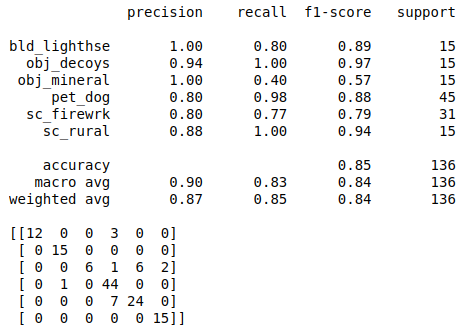

On peut voir que la précision avec ce modèle est plutôt correcte (0.85).

In [5]:
# On teste le modèle entrainé avec les données de test
y_pred = model.predict_classes(batch_holder)

classification = classification_report(y_true, y_pred, target_names=class_names)
confusion = confusion_matrix(y_true, y_pred)

print(classification)
print(confusion)

              precision    recall  f1-score   support

bld_lighthse       1.00      0.80      0.89        15
  obj_decoys       0.94      1.00      0.97        15
 obj_mineral       1.00      0.40      0.57        15
     pet_dog       0.80      0.98      0.88        45
  sc_firewrk       0.80      0.77      0.79        31
    sc_rural       0.88      1.00      0.94        15

    accuracy                           0.85       136
   macro avg       0.90      0.83      0.84       136
weighted avg       0.87      0.85      0.84       136

[[12  0  0  3  0  0]
 [ 0 15  0  0  0  0]
 [ 0  0  6  1  6  2]
 [ 0  1  0 44  0  0]
 [ 0  0  0  7 24  0]
 [ 0  0  0  0  0 15]]


## Mise en forme des données

Ici, on crée le dossier qui contiendra les résultats si celui-ci n'existe pas.

In [6]:
resu_dir = "./datap2/res"
if not os.path.exists(resu_dir):
    os.mkdir(resu_dir)

Ici, on vide le dossier qui contiendra le résultat des prédictions pour pouvoir le remplir avec les prédictions effectuées à l'instant.

In [7]:
# On vide les dossiers résultat avant utilisation
print("\nSuppression des résultats des exécutions précédentes")
repertoire = "./datap2/res"
for classe in os.listdir(repertoire) :
    for filename in os.listdir(repertoire + "/" + classe) :
        os.remove(repertoire + "/" + classe + "/" + filename)


Suppression des résultats des exécutions précédentes


Ici, on crée les différentes classes à prédire dans le dossier "./datap2/res".

In [8]:
# Création des dossiers qui représentent les classes pour y mettre les résultats
for dirpath, dirnames, filenames in os.walk(repertoire_test):
    structure = os.path.join(resu_dir, os.path.relpath(dirpath, repertoire_test))
    if not os.path.isdir(structure):
        os.mkdir(structure)

Enfin, ici, on met les images dans les classes prédites corerspondantes. Cela permet d'y avoir accès directement et de pouvoir avoir accès au résultat directement depuis l'explorateur de fichiers.

In [9]:
# On met les résultats dans les classes correspondantes
print("\nCopie des résultats dans les classes cibles")
i = 0
for dirpath, dirnames, filenames in os.walk(repertoire_test):
    structure = os.path.join(resu_dir, os.path.relpath(dirpath, repertoire_test))
    for imgnm in filenames:
        shutil.copy(dirpath + '/' + imgnm, resu_dir + '/' + class_names[y_pred[i]] + '/' + imgnm)
        i = i + 1


Copie des résultats dans les classes cibles


## Conclusion

Cette méthode, la méthode New School, se base sur un réseau de neurones. Ce réseau prend en entrée des images pour s'entraîner et donne leur classe d'appartenance en résultat.

Nous avons pu voir que, même avec un petit jeu de données, il est possible d'avoir un système qui prédit plutôt bien les classes d'appartenance des images en entrée. Comme nous avons pu le voir précédemment, la précision était de 0.85. C'est toutefois moins élevé que la méthode Old School, mais, c'est logiquement plus robuste.</br>
En effet, dans la méthode Old School, on se base uniquement sur les couleurs. Si nos images ont des couleurs similaires, la précision va sensiblement baisser. Dans le cas de la méthode New School, le système se base sur un plus grand nombre de données pour caractériser les images, ce qui le rend plus robuste en théorie.